# Ⅴ. 분류

In [1]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l


from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. 나이브 베이즈
---
- **나이브 베이즈(naive Bayes) 알고리즘**: 주어진 결과에 대해 독립변숫값을 관찰할 확률을 사용하여, 독립변수가 주어졌을 때 결과 $Y=i$를 관찰할 확률 추정
    - 즉 정말 관심있는 것을 추정함
- **조건부확률(conditional probability)**: 어떤 사건($Y=i$)이 주어졌을 때, 해당 사건($X=i$)을 관찰할 확률 $P(X_i|Y_i)$
- **사후확률(posterior probability)**: 예측 정보를 통합한 후 결과의 확률
    - 이와 달리 **사전확률**에서는 독립변수에 대한 정보를 고려하지 않음

- 완전한 베이즈 분류
    1. 예측변수의 값이 동일한(=예측변수 프로파일이 동일한) 모든 레코드들을 찾는다.
    1. 해당 레코드들이 가장 많이 속한(=가능성이 가장 많은) 클래스를 정한다.
    1. 새 레코드에 해당 클래스를 지정한다.

### A. 나이브하지 않은 베이즈 분류는 왜 현실성이 없을까?
---
독립변수의 개수가 일정 정도 커지게 되면, 분류해야 하는 데이터들 대부분 서로 완전 일치하는 경우가 거의 없기 때문이다.

```
※ 나이브 베이즈는 베이즈 통계의 방법으로 간주되지 않는다.

나이브 베이즈는 상대적으로 통계 지식이 거의 필요 없는 데이터 중심의 경험적 방법이다.
베이즈 규칙과 비슷한 예측 계산이 들어가다 보니 이름을 그렇게 붙였을 뿐이다.
```

### B. 나이브한 해법
---
확률을 계산하기 위해 정확히 일치하는 레코드로만 제한할 필요가 없고, 대신 전체 데이터를 활용한다.

- 나이브 베이즈 방법에서 바뀌는 부분
    1. 이진 응답 $Y=i$($i=0$ 또는 $i=1$)에 대해, 각 독립변수에 대한 조건부확률 $P(X_j|Y=i)$를 구한다.
        - $Y=i$가 주어질 때 독립변수의 값이 나올 확률
        - 훈련 데이터(training set)에서 $Y=i$인 레코드들 중 $X_j$의 비율로 구할 수 있음
    1. 각 확률값을 곱한 다음, $Y=i$에 속한 레코드들의 비율을 곱한다.
    1. 모든 클래스에 대해 1~2단계를 반복한다.
    1. 2단계에서 모든 클래스에 대해 구한 확률값을 모두 더한 값으로 클래스 $i$의 확률을 나누면 결과 $i$의 확률을 구할 수 있다.
    1. 이 독립변수에 대해 가장 높은 확률을 갖는 클래스를 해당 레코드에 할당한다.

- 독립변수 $X_1, \cdots, X_p$가 주어졌을 때의 output $Y=i$의 확률에 대한 방정식으로 표현
    - $P(Y=i|X_1,X_2,\cdots,X_p)$
- 정확한 베이즈 분류를 사용하여 클래스 확률을 계산하기 위한 공식
    - $P(Y=i|X_1,X_2,\cdots,X_p)={{P(Y=i)P(X_1,\cdots,X_p|Y=i)} \over {P(Y=0)P(X_1,\cdots,X_p|Y=0)+P(Y=1)P(X_1,\cdots,X_p|Y=1)}}$
- 조건부 독립성에 대한 나이브 베이즈 가정하에서 이 방정식을 다음과 같이 전개
    - $P(Y=i|X_1,X_2,\cdots,X_p)={{P(Y=i)P(X_1|Y=i) \cdots P(X_p|Y=i)} \over {P(Y=0)P(X_1|Y=0) \cdots P(X_p|Y=0)+P(Y=1)P(X_1|Y=1) \cdots P(X_p|Y=1)}}$

- 왜 '나이브'하다고 부르는 걸까?
    - 결과가 주어졌을 때 독립변수 벡터의 정확한 조건부확률은 각 조건부확률 $P(X_j|Y=i)$의 곱으로 충분히 잘 추정할 수 있다는 단순한 가정 기초
    - $P(X_1,X_2,\cdots,|Y=i)$ 대신 $P(X_j|Y=i)$를 추정하면서, $X_j$가 $k≠j$인 모든 $X_k$와 서로 독립이라고 가정

In [3]:
loan_data = pd.read_csv('../data/loan_data.csv')

In [4]:
# 범주형 변수로 전환
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

# 더미 변수로 변환
predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', dtype=int)
y = loan_data[outcome]

# fitting
# sklearn.naive_bayes의 MultinomialNB
naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model = MultinomialNB(alpha=1e-10, fit_prior=False)
naive_model.fit(X, y)

MultinomialNB(alpha=1e-10, fit_prior=False)

In [5]:
# 테스트를 위해 데이터 집합의 마지막 값 사용
new_loan = X.loc[146:146, :]

# scikit-learn의 분류 모델
# 예측한 클래스를 반환하는 predict 메서드
print('predicted class: ', naive_model.predict(new_loan)[0])

predicted class:  default


- default = 연체
- paid off = 상환

In [6]:
# scikit-learn의 분류 모델
# 클래스 확률을 반환하는 predict_proba 메서드
probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)
print('predicted probabilities',)
print(probabilities)

predicted probabilities
    default  paid off
0  0.653699  0.346301


### C. 수치형 예측변수
---
- 베이즈 분류기는 독립변수들이 범주형인 경우에 적합
- 수치형 변수에 나이브 베이즈 방법을 적용하기 위해서는, 두 가지 접근법 중 하나를 따라야 함
    - 수치형 독립변수를 binning하여 범주형으로 변환한 뒤 알고리즘 적용
    - 조건부확률 $P(X_j|Y=i)$를 추정하기 위해 정규분포 같은 확률모형 사용

```
※ 예측변수의 특정 카테고리에 해당하는 데이터가 훈련 데이터에 없을 때

다른 기법들처러 이 변수를 무시하고 다른 변수들의 정보를 사용하는 대신, 나이브 베이즈 알고리즘은 새 데이터 결과에 대한 확률을 0으로 할당한다.
나이브 베이즈를 구현한 대부분의 경우에는 이를 방지하기 위해 평활화 인수를 사용한다.
```

## 2. 판별분석
---
- **판별분석(discriminant analysis)**: 초창기의 통계 분류 방법
- **공분산(covariance)**: 하나의 변수가 다른 변수와 함께 변화하는 정도(유사한 크기와 방향)를 측정하는 지표
- **판별함수(discriminant function)**: 독립변수에 적용했을 때, 클래스 구분을 최대화하는 함수
- **판별 가중치(discriminant weight)**: 판별함수를 적용하여 얻은 점수로, 어떤 클래스에 속할 확률을 추정하는 데 사용됨

```
※ 선형판별분석(Linear Discriminant Analysis) vs 잠재 디리슈레 할당(Latent Dirichlet Allocation)

잠재 디리슈레 할당은 텍스트와 자연어 처리에 사용되는 방법으로 선형판별분석과 아무런 관련이 없음
```

### A. 공분산행렬
---
- $x$와 $z$ 사이의 공분산 $s_{z,x}$
    - $\bar{x}$, $\bar{z}$: 각 변수의 평균
    - $n$: 레코드의 개수
    - $s_{z,x}={ {\sum_{i=1}^n \left(x_i-\bar{x}\right)\left(z_i-\bar{z}\right)} \over {n-1} }$
- $x$와 $z$에 대한 공분산행렬 $\Sigma$
    - 각 변수의 분산 $s_x^2$과 $s_z^2$을 대각원소로 놓고, 변수들 사이의 공분산을 비대각 원소에 위치시킨 행렬
    - $\hat{\Sigma}=\begin{bmatrix} s_x^2 & s_{x,z} \\ s_{z,x} & s_z^2 \end{bmatrix}$

### B. 피셔의 선형판별
---
- 그룹 안의 편차와 다른 그룹 간의 편차 구분
- 선형판별분석은 '내부'제곱합 $SS_{내부}$(두 그룹 안의 변동)에 대한 '사이'제곱합 $SS_{사이}$(두 그룹 사이의 편차)의 비율을 최대화 하는 것이 목표
    - $SS_{사이} \over SS_{내부}$
    - 사이 제곱합을 최대화하고 내부 제곱합을 최소화하는 것이 두 그룹 사이를 가장 명확하게 나누는 방법

### C. 간단한 예

In [7]:
loan3000 = pd.read_csv('../data/loan3000.csv')
loan3000.outcome = loan3000.outcome.astype('category')

In [8]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

# sklearn.discriminant_analysis의 LinearDiscriminantAnalysis
loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
print(pd.DataFrame(loan_lda.scalings_, index=X.columns)) #scalins_: 추정 가중치 제공

                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


In [9]:
# default(연체) 혹은 paid off(상환)에 대한 확률
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns=loan_lda.classes_)
print(pred.head())

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


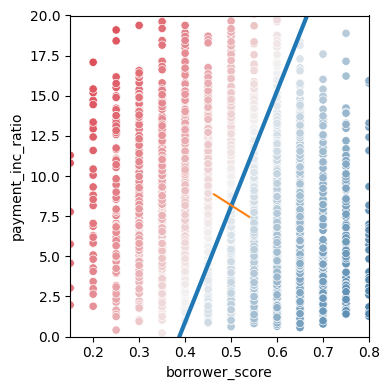

In [ ]:
# 스케일링 꼐수와 평균값의 중간값을 이용해 결정 경계 계산
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ratio가 0 또는 20이 되는 borrower_score 값 계산
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df,
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()
plt.show()

```
판별분석의 확장

독립변수가 더 많아질 경우
선형판별분석은 독립변수가 두 개보다 많아도 잘 동작한다.
공분산을 계산할 수 있을 만큼 충분한 수의 레코드가 있어야 한다.

이차판별분석(QDA)
이름과 달리 여전히 선형판별함수를 사용한다.
선형판별분석은 Y=0인 그룹과 Y=1인 그룹의 공분산행렬이 모두 동일해야 한다는 가정을 필요로 하지만, QDA에서는 이 두 그룹이 서로 다른 공분산을 가질 수 있다.
```

## 3. 로지스틱 회귀
---
- **로짓(logit)**: (0~1이 아니라) $±\infty$의 범위에서 어떤 클래스에 속할 확률을 결정하는 함수
    - 유의어 - 로그 오즈
- **오즈(odds**): '실패'(0)에 대한 '성공'(1)의 비율
- **로그 오즈(log odds)**: 변환 모델(선형)의 종속변수로, 이 값을 통해 확률을 구함

- k-최근접 이웃이나 나이브 베이즈와는 다르게, 로지스틱 회귀는 데이터 위주의 접근 방식이라기보다, 구조화된 모델 접근 방식이라 할 수 있음

### A. 로지스틱 반응 함수와 로짓
---
- 라벨이 '1'이 될 확률 $p$
- $p$를 독립변수들의 선형함수로 모델링
    - $p=\beta_0+\beta_1x_1+\beta_2x_2+\cdots+\beta_qx_q$
    - 이 모델을 피팅한다고 해도, 선형모델이다 보니 $p$가 0과 1 사이로 딱 떨어지지 않을 수 있음
    - 더는 확률이라고 할 수 없게 됨
- 예측변수에 로지스틱 반응 혹은 역 로짓 함수라는 것을 적용해서 $p$를 모델링
    - $p={1 \over {1+e^{-(\beta_0+\beta_1x_1+\beta_2x_2+\cdots+\beta_qx_q)} } }$
    - $p$가 항상 0에서 1 사이
    - 분모의 지수 부분을 구하려면 확률 대신 오즈비 이용
- 역오즈비 함수를 통해 확률값을 구할 수도 있음
    - $p={오즈 \over {1+오즈} }$
- 오즈 수식을 로지스틱 반응 함수에 적용
    - $오즈(Y=1)=e^{\beta_0+\beta_1x_1+\beta_2x_2+\cdots+\beta_qx_q}$
- 양변에 로그 함수
    - $log(오즈(Y=1))=\beta_0+\beta_1x_1+\beta_2x_2+\cdots+\beta_qx_q$
- 로그 오즈 함수 또는 로짓 함수는 0과 1 사이의 확률 $p$를 $-\infty$에서 $+\infty$까지의 값으로 매핑

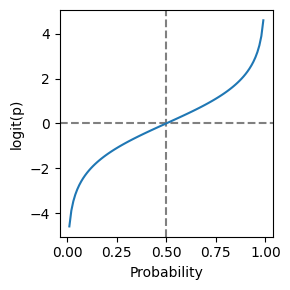

In [11]:
p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1 - p)),
    'odds': p / (1 - p),
})

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0.5, color='grey', linestyle='--')
ax.plot(df['p'], df['logit'])
ax.set_xlabel('Probability')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()

### B. 로지스틱 회귀와 GLM
---
- 앞서 유도한 로지스틱 회귀방정식에서 종속변수는, 1의 이진 출력에 대한 로그 오즈 값
- 우리가 실제 관찰한 데이터는 로그 오즈 값이 아닌 이진 출력값
- 이 방정식을 fitting하기 위해, 선형회귀를 확장한 GLM의 특별한 사례인 로지스틱 회귀 필요

In [ ]:
# outcome: 종속변수. 대출을 모두 갚았으면 0, 연체이면 1
# purpose_ / home_: 대출 목적 / 주택 소유 상태
# borrower_score: 차용인의 신용도를 나타내는 0에서 1까지의 점수
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_',
              'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='',
                   drop_first=True, dtype=int)
y = loan_data[outcome] # .cat.categories

In [13]:
print(loan_data['purpose_'].cat.categories)
print(loan_data['home_'].cat.categories)
print(loan_data['emp_len_'].cat.categories)

Index(['credit_card', 'debt_consolidation', 'home_improvement',
       'major_purchase', 'medical', 'other', 'small_business'],
      dtype='object')
Index(['MORTGAGE', 'OWN', 'RENT'], dtype='object')
Index([' < 1 Year', ' > 1 Year'], dtype='object')


In [ ]:
# sklearn.linear_model의 LogisticRegression
# L1 또는 L2 정규화에 의한 과적합 방지 -> penalty와 C 인수 사용
# solver = 사용할 최소화 방법 선택
logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]},
             index=X.columns)

intercept  -1.6380887349416688
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079728
borrower_score,4.611037
debt_consolidation,-0.249342
home_improvement,-0.407614
major_purchase,-0.229375
medical,-0.510087
other,-0.620534
small_business,-1.215662
OWN,-0.048452
RENT,-0.157355


- R과 달리 $y$에서 하나의 값(상환 혹은 연체)으로 클래스 결정
- 내부적으로 클래스를 알파벳순 정렬 -> R에 사용된 요인과 반대 방향 -> R의 결과와 계수 부호가 반대로 나옴

In [ ]:
# 범주형 변수를 숫자로 변환
# paid off = 0 / default = 1
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=[['paid off', 'default']])
y_enc = enc.fit_transform(loan_data[[outcome]]).ravel()

logit_reg_enc = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg_enc.fit(X, y_enc)

print('intercept ', logit_reg_enc.intercept_[0])
print('classes', logit_reg_enc.classes_)
pd.DataFrame({'coeff': logit_reg_enc.coef_[0]},
             index=X.columns)

intercept  1.637890833061857
classes [0. 1.]


,coeff
payment_inc_ratio,0.079739
borrower_score,-4.612183
debt_consolidation,0.249414
home_improvement,0.407734
major_purchase,0.229710
medical,0.510744
other,0.620800
small_business,1.214936
OWN,0.048211
RENT,0.157288


- R과 동일한 결과
- 이전의 방식과 계수 부호 반대

### C. 일반화선형모형
---
- 주요 구성 요소
    - 확률분포 또는 분포군 (로지스틱 회귀의 경우 이항분포)
    - 응답을 독립변수에 매핑하는 연결(혹은 변형) 함수 (로지스틱 회귀의 경우 로짓)

### D. 로지스틱 회귀의 예측값
---
- = 로그 오즈 $\hat{Y}=log(오즈(Y=1))$에 관한 값
- 예측된 확률은 로지스틱 반응 함수에 의해 주어짐
    - $\hat{p}={1 \over {1+e^{-\hat{Y} } } }$

In [16]:
# 예측값 확률을 데이터 프레임으로 변환
# describe 메서드로 분포의 특성 확인
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean      -0.757850     -0.760423
std        0.378032      0.390419
min       -2.768873     -3.538864
25%       -0.985728     -0.977164
50%       -0.697366     -0.688946
75%       -0.472209     -0.467076
max       -0.029476     -0.064787


In [17]:
# prdeict_proab 메서드로 확률 직접 계산
pred = pd.DataFrame(logit_reg.predict_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean       0.500001      0.499999
std        0.167336      0.167336
min        0.062733      0.029046
25%        0.373167      0.376377
50%        0.497895      0.502105
75%        0.623623      0.626833
max        0.970954      0.937267


- 0과 1 사이에 있을 뿐 아직 이 예측 결과가 연체인지 아니면 빚을 갚는 것인지 불분명함

### E. 계수와 오즈비 해석하기
---
- 로지스틱 회귀의 장점
    - 재계산 없이 새 데이터에 대해 결과를 빨리 계산할 수 있음
    - 다른 분류 방법들에 비해 모델을 해석하기가 상대적으로 쉬움
- 오즈비 이해 - 요인변수 $X$
    - $오즈비={ {오즈(Y=1|X=1)} \over {오즈(Y=1|X=0)} }$
- 로지스틱 회귀분석에서 계수 $\beta_j$는 $X_j$에 대한 오즈비의 로그값

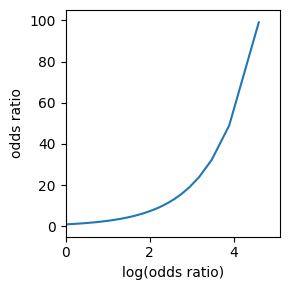

In [18]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(df['logit'], df['odds'])
ax.set_xlabel('log(odds ratio)')
ax.set_ylabel('odds ratio')
ax.set_xlim(0, 5.1)
ax.set_ylim(-5, 105)

plt.tight_layout()
plt.show()

- Ⅴ.3.B에서 구한 모델에서, 변수 purpose_small_business에 대한 회귀 계수는 $1.21526$
- 신용 카드 빚을 갚기 위한 대출과 비교했을 때, 소규모 사업을 위한 대출은 $exp(1.21526) \approx 3.4$만큼 대출 상환 대비 연체의 오즈비가 증가함
- 계수가 로그 스케일 -> 계수가 1만큼 증가할수록 결과적으로 오즈비는 $exp(1) \approx 2.72$만큼 증가

### F. 선형회귀와 로지스틱 회귀: 유사점과 차이점
---
- 유사점
    - 독립변수와 종속변수를 선형 관계로 가정함
    - 가장 좋은 모델을 탐색하고 찾는 과정
    - 독립변수에 스플라인 변환을 사용하는 방법
- 차이점
    - 모델을 fitting하는 방식
        - 로지스틱 회귀
            - 최소제곱을 사용할 수 없음
            - 최대우도추정(MLE)을 사용하여 모델 fitting
                - 최대우도추정: 보고 있는 데이터를 생성했을 가능성이 가장 큰 모델을 찾는 프로세스
                - MLE의 목표 = 주어진 모델 $P$에서 $(X_1,X_2,\cdots,X_n)$을 관측할 확률 최대화
            - 편차를 사용하여 모델 평가
                - $편차=-2log(P_{\hat{\Theta} }(X_1,X_2,\cdots,X_n))$
                - 편차가 작을수록 모델 적합도가 높음
        - 선형회귀
            - 최소제곱 사용
            - RMSE와 R 제곱 통계량을 사용하여 성능 평가
    - 모델에서 잔차의 특징과 분석
        - 로지스틱 회귀
            - 결과변수가 이진형이므로 잔차의 형태가 다름
                - 항상 유한한 값인 로짓(오즈비의 로그값)으로 예측을 측정
                - 실제 값(절댓값 0 또는 1)은 양수 혹은 음수 무한대인 로짓에 해당하므로 (적합값에 더해지는) 잔차는 절대로 0이 될 수 없음
                - 따라서 편잔차 그래프에서 점들은 적합한 선 위와 아래에 구름처럼 퍼져 있음
            - 선형회귀에서보다 덜 중요하긴 하지만, 비선형성을 검증하고 영향력이 큰 레코드들을 확인하는 데 여전히 유용함

### G. 모델 평가하기

In [ ]:
# statmodels의 GLM
# use GLM (general linear model) with the binomial family to fit a logistic regression
y_numbers = [1 if yi == 'default' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1),
                      family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Wed, 19 Feb 2025   Deviance:                       57515.
Time:                        14:39:04   Pearson chi2:                 4.54e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1112
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0

- p 값을 통계적인 유의성을 측정하는 지표로 보기보다는 변수의 중요성을 나타내는 상대적인 지표로 봐야 함
- RMSE나 R 제곱이 있을 수 없고 대신 분류 문제에서 가장 일반적으로 사용되는 측정 지표들을 사용할 수 있음
- 로지스틱 회귀에서도 단계적 회귀, 상호작용 항 도입, 스플라인 항 포함 등을 모두 사용할 수 있음

In [20]:
# statsmodels의 formula 인터페이스를 확장해서 사용
# splines
import statsmodels.formula.api as smf
formula = ('outcome ~ bs(payment_inc_ratio, df=8) + purpose_ + ' +
           'home_ + emp_len_ + bs(borrower_score, df=3)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45321
Model Family:                                       Binomial   Df Model:                           20
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -28731.
Date:                                       Wed, 19 Feb 2025   Deviance:                       57462.
Time:                                               14:39:04   Pearson chi2:                 4.54e+04
No. Iterations:                                            6   Pseudo R-squ. (CS):             0.1122
Covariance Type:                                   nonrobust                      

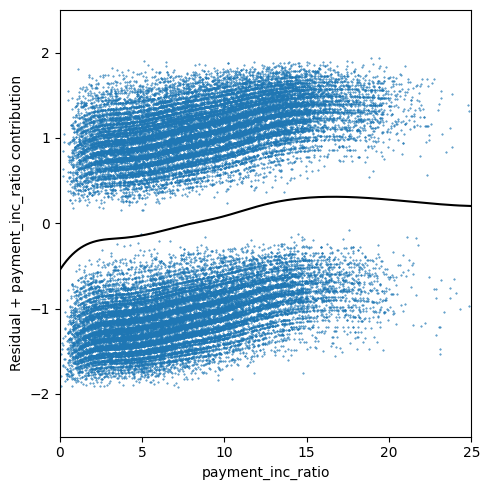

In [21]:
# 편잔차 그래프
from statsmodels.genmod.generalized_linear_model import GLMResults
def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # set model parametes of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params.iloc[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/ 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)


plt.tight_layout()
plt.show()

## 4. 분류 모델 평가하기
---
- **정확도(accuracy)**: 정확히 분류된 비율
- **혼동행렬(cofusion matrix)**: 분류에서 예측된 결과와 실제 결과에 대한 레코드의 개수를 표시한 테이블 (이진형인 경우 2×2)
- **민감도(sensitivity)**: 1을 정확히 1로 분류한 비율
    - 유의어 - **재현율(recall)**
- **특이도(specificity)**: 0을 정확히 0으로 분류한 비율
- **정밀도(precision)**: 1이라고 예측한 것들 중에 1이 맞는 경우의 비율
- **ROC 곡선(ROC curve)**: 민감도와 특이도를 표시한 그림
- **리프트(lift)**: 모델이 다른 확률 컷오프에 대해 (비교적 드문) 1을 얼마나 더 효과적으로 구분하는지 나타내는 측정 지표

$정확도={ {\sum 참 양성+\sum 참 음성} \over {표본 크기} }$

### A. 혼동행렬

In [22]:
# Confusion matrix
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == 'default'
true_y = y == 'default'
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = default', 'Y = paid off'],
                       columns=['Yhat = default', 'Yhat = paid off'])
print(conf_mat)

              Yhat = default  Yhat = paid off
Y = default            14336             8335
Y = paid off            8148            14523


In [23]:
print(confusion_matrix(y, logit_reg.predict(X)))

[[14336  8335]
 [ 8148 14523]]


In [ ]:
# dmba의 classificationSummary
classificationSummary(y, logit_reg.predict(X),
                      class_names=logit_reg.classes_)

Confusion Matrix (Accuracy 0.6365)

         Prediction
  Actual  default paid off
 default    14336     8335
paid off     8148    14523


- 열 = 예측값
- 행 = 실제 결과
- 대각원소 = 정확히 예측한 데이터의 수
- 비대각원소 = 부정확한 예측의 수

[혼동행렬과 관련 지표](https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEiqxBWDxr82HWBNDD-XI22ht1rEZdhCUXilxAMtKFQugD4WxvEUUfqBv6fZfPwQ7MZZn_AM-xXGjhl2yeaHfWq47U2yKuigKcqy3wi5LQx7ExuJEnkdIJfyZHjpzRCkbYXil8z69kLf4a2_/s1600/confusionMatrxiUpdated.jpg)

### B. 희귀 클래스 문제

### C. 정밀도, 재현율, 특이도
---
- 정밀도: 예측된 양성 결과의 정확도
    - $\sum 참양성 \over {\sum 참양성+\sum 거짓양성}$
- 민감도(재현율): 양성 결과를 정확히 예측하는 모델의 능력
    - $\sum 참양성 \over {\sum 참양성+\sum 거짓음성}$
- 특이도: 음성 결과를 정확히 예측하는 모델의 능력
    - $\sum 참음성 \over {\sum 참음성+\sum 거짓양성}$

In [25]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))
print('Precision', conf_mat[0, 0] / sum(conf_mat[:, 0]))
print('Recall', conf_mat[0, 0] / sum(conf_mat[0, :]))
print('Specificity', conf_mat[1, 1] / sum(conf_mat[1, :]))

Precision 0.6376089663760897
Recall 0.6323496978518812
Specificity 0.6405981209474659


In [ ]:
# scikit-learn의 precision_recall_fscore_support
# precision, recall, fbeta_score, support
precision_recall_fscore_support(y, logit_reg.predict(X),
                                labels=['default', 'paid off'])

(array([0.63760897, 0.63535742]),
 array([0.6323497 , 0.64059812]),
 array([0.63496844, 0.63796701]),
 array([22671, 22671], dtype=int64))

### D. ROC곡선
---
- 재현율과 특이도 사이에는 트레이드오프 관계가 있음
    - 1을 잘 잡아낸다는 것은 그만큼 0을 1로 잘못 예측할 가능성도 높음
- 이러한 트레이드오프 관계를 표현하기 위한 지표 = ROC 곡선
- x축의 특이도에 대한 y축의 재현율(민감도) 표시

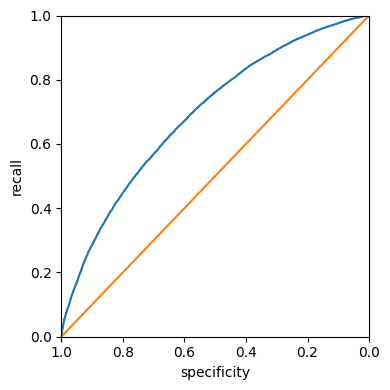

In [ ]:
# sklearn.metrics의 roc_curve
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:, 0],
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')


plt.tight_layout()
plt.show()

```
ROC 곡선과 함께 정밀도-재현율(PR) 곡선을 사용하기도 한다.
```

### E. AUC
---
- ROC 곡선의 곡선 아래 면적(Areas Underneath the Curve)
- AUC 값이 높을수록 더 좋은 분류기
- AUC가 1이라는 것은 0을 1로 잘못 예측하는 경우 없이 1을 정확히 분류하는 완벽한 분류기
- ROC 곡선이 가운데를 지나가는 직선인 경우, 즉 AUC가 0.5인 경우가 최악의 분류기

In [28]:
# sklearn.metrics의 roc_auc_score
print(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)))
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y], logit_reg.predict_proba(X)[:, 0]))

0.6917107991799145
0.6917108770048264


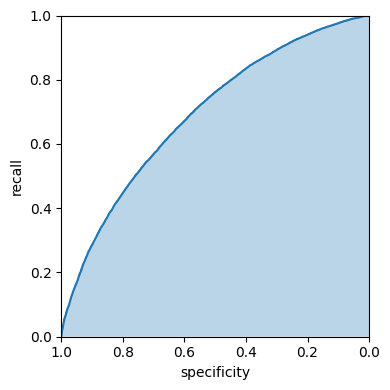

In [ ]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0],
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
# ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()

### F. 리프트
---
- 희귀 케이스 문제에서는 모든 레코드를 0으로 분류하지 않도록 모델의 확률 컷오프를 0.5 미만으로 낮춰야 함
- 1의 중요성을 너무 크게 반영하여 1을 과대평가하는 결과를 낳을 수 잇음
- 리프트 차트를 계산하려면 y축에 재현율을 그리고 x축에 총 레코드 수를 나타내는 누적 이득 차트를 먼저 작성해야 함
- 리프트 곡선은 임의 선택을 의미하는 대각선에 대한 누적이득의 비율

## 5. 불균형 데이터 다루기
---
- **과소표본(undersample)**: 분류 모델에서 개수가 많은 클래스 데이터 중 일부 소수만을 사용하는 것
    - 유의어 - 다운샘플
- **과잉표본(oversample)**: 분류 모델에서 희귀 클래스 데이터를 중복하여, 필요하면 부트스트랩해서 사용하는 것
    - 유의어 - 업샘플
- **상향 가중치(up weight)** 혹은 **하향 가중치(down weight)**: 모델에서 희귀(혹은 다수) 클래스에 높은(혹은 낮은) 가중치를 주는 것
- **데이터 생성(data generation)**: 부트스트랩과 비슷하게 다시 샘플링한 레코드를 빼고 원본과 살짝 다르게 데이터를 생성하는 것
- **z 점수(z-score)**: 표준화 결과
- **k**: 최근접 이웃 알고르짐에서 이웃들의 개수

### A. 과소표본추출
---
- 데이터 개수가 충분하다면, 다수의 데이터에 해당하는 클래스에서 과소표본추출을 하여 모델링할 때 0과 1의 데이터 개수에 균형을 맞출 수 있음

In [30]:
full_train_set = pd.read_csv('../data/full_train_set.csv')
print(full_train_set.shape)

(119987, 19)


In [ ]:
print('percentage of loans in default: ',
print(      100 * np.mean(full_train_set.outcome == 'default')))

18.894546909248504
percentage of loans in default:  None


In [ ]:
# 전체 데이터를 사용하는 경우
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_',
              'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'
X = pd.get_dummies(full_train_set[predictors], prefix='', prefix_sep='',
                   drop_first=True, dtype=int)
y = full_train_set[outcome]

full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y)
print('percentage of loans predicted to default: ',
print(      100 * np.mean(full_model.predict(X) == 'default')))

1.0067757340378543
percentage of loans predicted to default:  None


In [ ]:
(np.mean(full_train_set.outcome == 'default') /
 np.mean(full_model.predict(X) == 'default'))

18.767384105960264

### B. 과잉표본추출과 상향/하향 가중치
---
- 희귀 클래스의 경우 복원추출 방식(부트스트래핑)으로 과잉표본추출해야 함
- 데이터의 가중치를 적용하는 방식으로 비슷한 효과를 얻을 수 있음

In [ ]:
default_wt = 1 / np.mean(full_train_set.outcome == 'default')
wt = [default_wt if outcome == 'default' else 1 for outcome in full_train_set.outcome]

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X, y, wt)
print('percentage of loans predicted to default (weighting): ',
print(      100 * np.mean(full_model.predict(X) == 'default')))

61.03494545242402
percentage of loans predicted to default (weighting):  None


### C. 데이터 생성
---
- 부트스트랩을 통한 업샘플링 방식의 변형
- 기존에 존재하는 데이터를 살짝 바꿔 새로운 레코드 생성
- SMOTE 알고리즘

In [ ]:
# imbalanced-learn
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print('percentage of loans in default (SMOTE resampled): ',
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (SMOTE): ',
      100 * np.mean(full_model.predict(X) == 'default'))


X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print('percentage of loans in default (ADASYN resampled): ',
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (ADASYN): ',
print(      100 * np.mean(full_model.predict(X) == 'default')))

percentage of loans in default (SMOTE resampled):  50.0
percentage of loans predicted to default (SMOTE):  29.312342170401795
percentage of loans in default (ADASYN resampled):  48.56040383751355
27.167109770225107
percentage of loans predicted to default (ADASYN):  None


### D. 비용 기반 분류

### E. 예측 결과 분석

In [36]:
loan3000 = pd.read_csv('../data/loan3000.csv')

In [ ]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

logit_reg = LogisticRegression(penalty="l2", solver='liblinear')
logit_reg.fit(X, y)


## model
gam = LinearGAM(s(0) + s(1))
print(gam.gridsearch(X.values, [1 if yi == 'default' else 0 for yi in y]))

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)


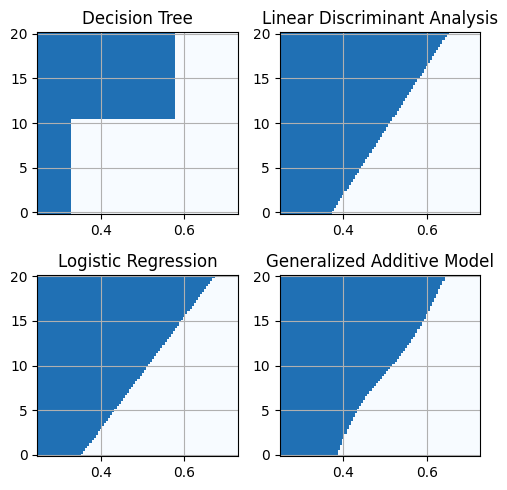

In [ ]:
models = {
    'Decision Tree': loan_tree,
    'Linear Discriminant Analysis': loan_lda,
    'Logistic Regression': logit_reg,
    'Generalized Additive Model': gam,
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

xvalues = np.arange(0.25, 0.73, 0.005)
yvalues = np.arange(-0.1, 20.1, 0.1)
xx, yy = np.meshgrid(xvalues, yvalues)
X = pd.DataFrame({
    'borrower_score': xx.ravel(),
    'payment_inc_ratio': yy.ravel(),
})

boundary = {}

for n, (title, model) in enumerate(models.items()):
    ax = axes[n // 2, n % 2]
    predict = model.predict(X)
    if 'Generalized' in title:
        Z = np.array([1 if z > 0.5 else 0 for z in predict])
    else:

        Z = np.array([1 if z == 'default' else 0 for z in predict])
    Z = Z.reshape(xx.shape)
    boundary[title] = yvalues[np.argmax(Z > 0, axis=0)]
    boundary[title][Z[-1,:] == 0] = yvalues[-1]

    c = ax.pcolormesh(xx, yy, Z, cmap='Blues', vmin=0.1, vmax=1.3, shading='auto')
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()